In [1]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV


## Matrix factorization using surprise library

In [83]:
file_path = os.path.expanduser("../output/score_matrix_nomix.csv")

In [84]:
reader = Reader(sep=",", skip_lines=1, rating_scale=(1, 10))
data = Dataset.load_from_file(file_path, reader)

### Simple test with train/test split, no hyperparams tuning

In [15]:
trainset, testset = train_test_split(data, test_size=0.3)

In [16]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [17]:
accuracy.rmse(predictions)

RMSE: 0.6416


0.6415869763994277

### Testing possible predictions with full dataset

In [18]:
train = data.build_full_trainset()

In [19]:
algo.fit(train)

In [21]:
X = np.zeros((3179, 494))
for d in tqdm(range(0, 3179)):
    for n in range(0, 494):
        X[d,n] = algo.predict(str(d),str(n))[3]

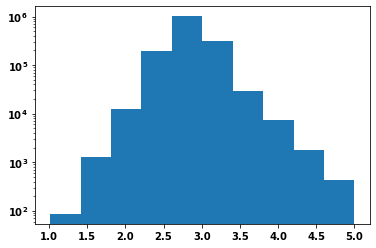

In [22]:
plt.hist(X.flatten())
plt.yscale("log")

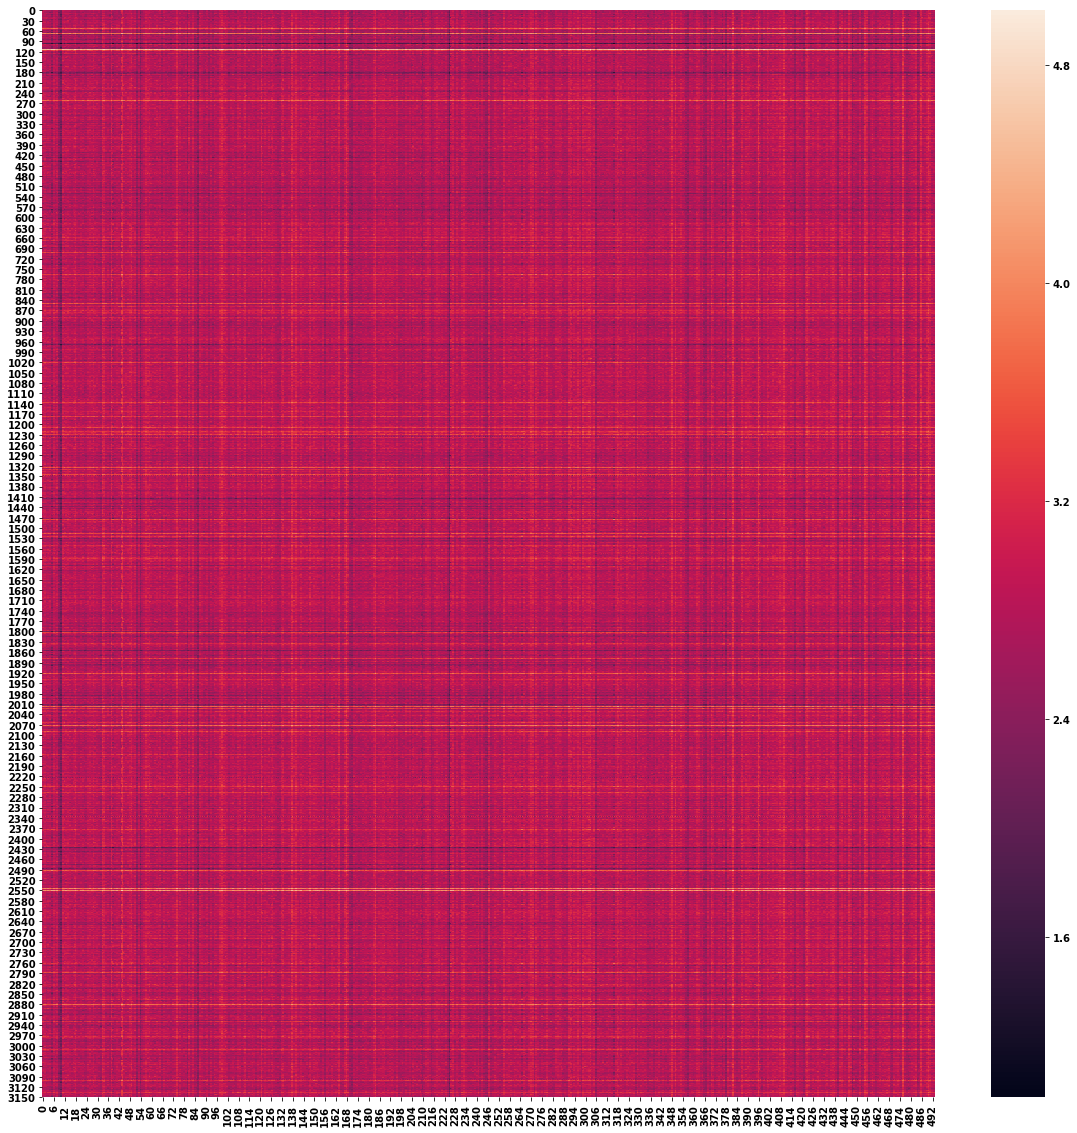

In [23]:
plt.figure(figsize=(20, 20))
sns.heatmap(X)

In [24]:
pd.DataFrame(X).to_csv("../output/fact1_result.csv")

### Implementing CV to choose params

In [ ]:
param_grid = {'lr_all': np.logspace(-4, 0, 20),
              'reg_all': np.logspace(-4, 0, 20),
              'n_factors': range(1, 1001)}

gs = RandomizedSearchCV(SVD, param_grid, n_iter = 500, measures=['rmse'], cv=5, n_jobs = -2, joblib_verbose=2)
gs.fit(data)

In [178]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.17176220014123145}
{'rmse': {'lr_all': 0.14384498882876628, 'reg_all': 0.03359818286283781, 'n_factors': 479}}


In [180]:
param_grid = {'lr_all': np.logspace(-1, 0, 20),
              'reg_all': np.logspace(-2, 0, 20),
              'n_factors': range(400, 501)}

gs = RandomizedSearchCV(SVD, param_grid, n_iter = 100, measures=['rmse'], cv=5, n_jobs = -2, joblib_verbose=2)
gs.fit(data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:  5.8min finished


In [181]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.17367612380485925}
{'rmse': {'lr_all': 0.16237767391887217, 'reg_all': 0.026366508987303583, 'n_factors': 425}}


Good enough params. Fitting the model:

In [186]:
s = SVD(n_factors=479, lr_all = 0.16237767391887217, reg_all = 0.026366508987303583)
s.fit(train)

In [193]:
for d in tqdm(range(0, 3179)):
    for n in range(0, 494):
        X[d,n] = s.predict(str(d),str(n))[3]

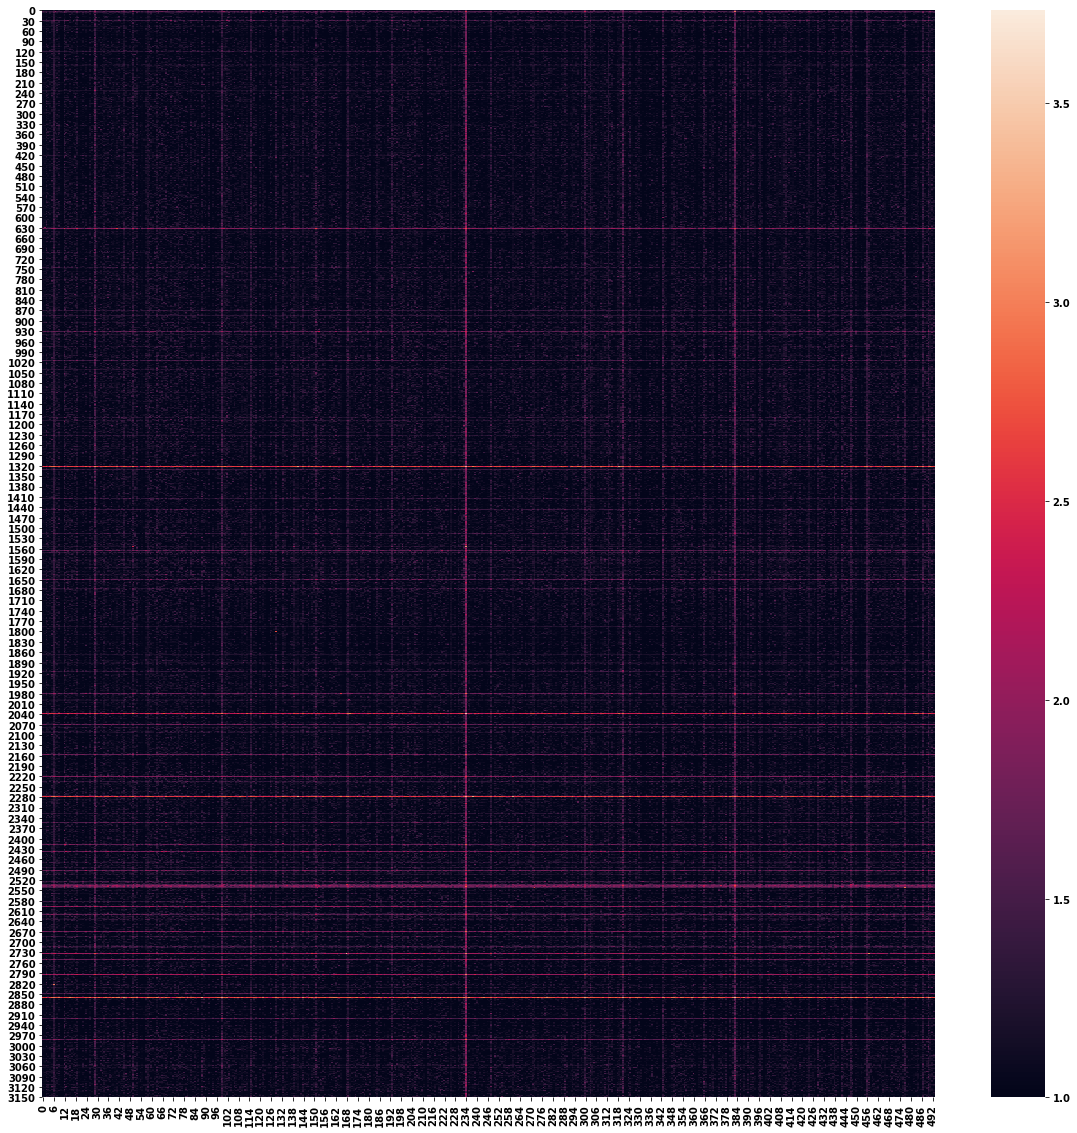

In [194]:
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(X)

## Another test using different scoring method

In [6]:
file_path = os.path.expanduser("../output/score_matrix_cat.csv")
reader = Reader(sep=",", skip_lines=1)
data = Dataset.load_from_file(file_path, reader)

In [7]:
trainset, testset = train_test_split(data, test_size=0.3)
fact2 = SVD()
fact2.fit(trainset)
predictions = fact2.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6348


0.6348287059029776

In [8]:
train = data.build_full_trainset()
fact2.fit(train)

In [9]:
X2 = np.zeros((3179, 494))
for d in tqdm(range(0, 3179)):
    for n in range(0, 494):
        X2[d,n] = fact2.predict(str(d),str(n))[3]

In [10]:
X2 = np.rint(X2)

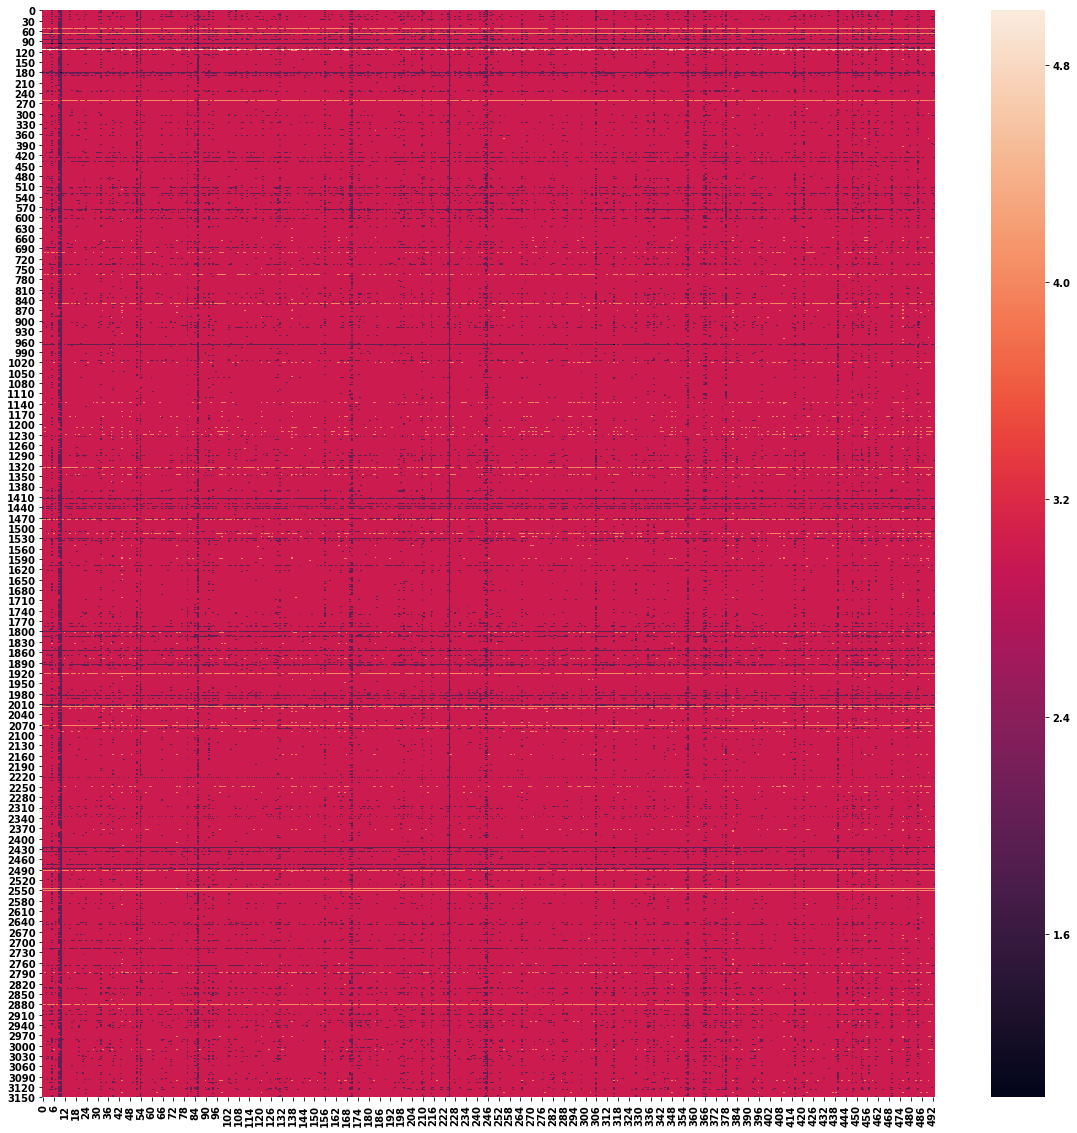

In [11]:
plt.figure(figsize=(20, 20))
sns.heatmap(X2)

In [13]:
pd.DataFrame(X2).to_csv("../output/fact2_result.csv")

# NEW TENTATIVE

## Only 96h

In [25]:
file_path = os.path.expanduser("../output/score_matrix_96h.csv")
reader = Reader(sep=",", skip_lines=1, rating_scale=(1, 20))
data = Dataset.load_from_file(file_path, reader)

In [26]:
trainset, testset = train_test_split(data, test_size=0.3)
fact2 = SVD()
fact2.fit(trainset)
predictions = fact2.test(testset)
accuracy.rmse(predictions)

RMSE: 1.6503


1.6502943616295813

In [27]:
train = data.build_full_trainset()
fact2.fit(train)

In [28]:
fact2.predict(str(0), str(71))

Prediction(uid='0', iid='71', r_ui=None, est=7.666183290283772, details={'was_impossible': False})

In [30]:
X3 = np.zeros((2582, 416))
for d in tqdm(range(0, 2582)):
    for n in range(0, 416):
        X3[d,n] = fact2.predict(str(d),str(n))[3]

In [31]:
X3[0, 71]

7.666183290283772

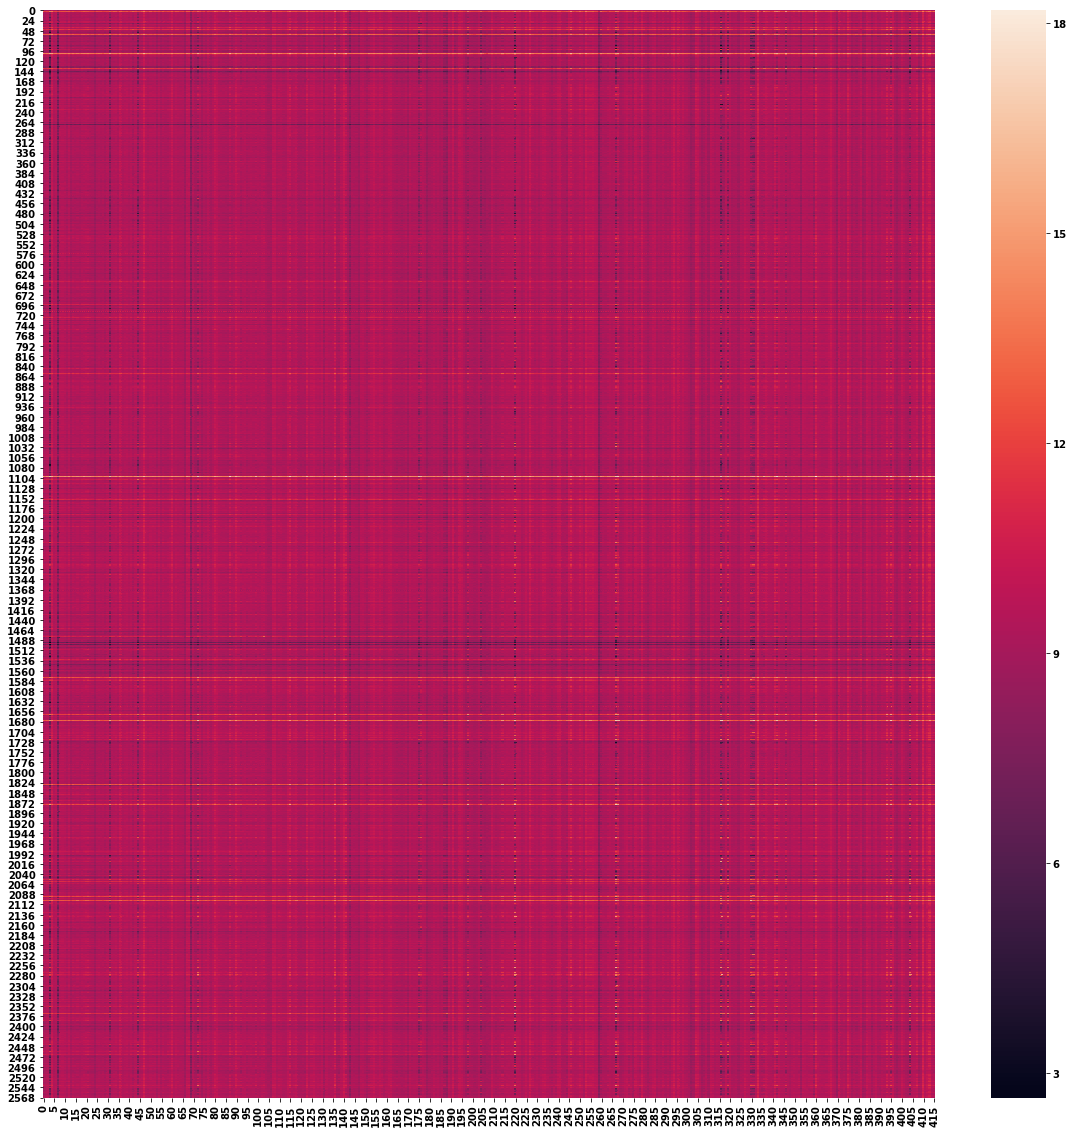

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(X3)

In [33]:
pd.DataFrame(X3).to_csv("../output/fact3_result.csv")

## CV

In [34]:
param_grid = {'lr_all': np.logspace(-4, 0, 20),
              'reg_all': np.logspace(-4, 0, 20),
              'n_factors': range(1, 1001)}

gs = RandomizedSearchCV(SVD, param_grid, n_iter = 100, measures=['rmse'], cv=5, n_jobs = -2, joblib_verbose=2, refit=True)
gs.fit(data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:  4.7min finished


In [35]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 1.4895648320723296}
{'rmse': {'lr_all': 0.05455594781168514, 'reg_all': 0.05455594781168514, 'n_factors': 131}}


In [36]:
X3 = np.zeros((2582, 416))
for d in tqdm(range(0, 2582)):
    for n in range(0, 416):
        X3[d,n] = gs.predict(str(d),str(n))[3]

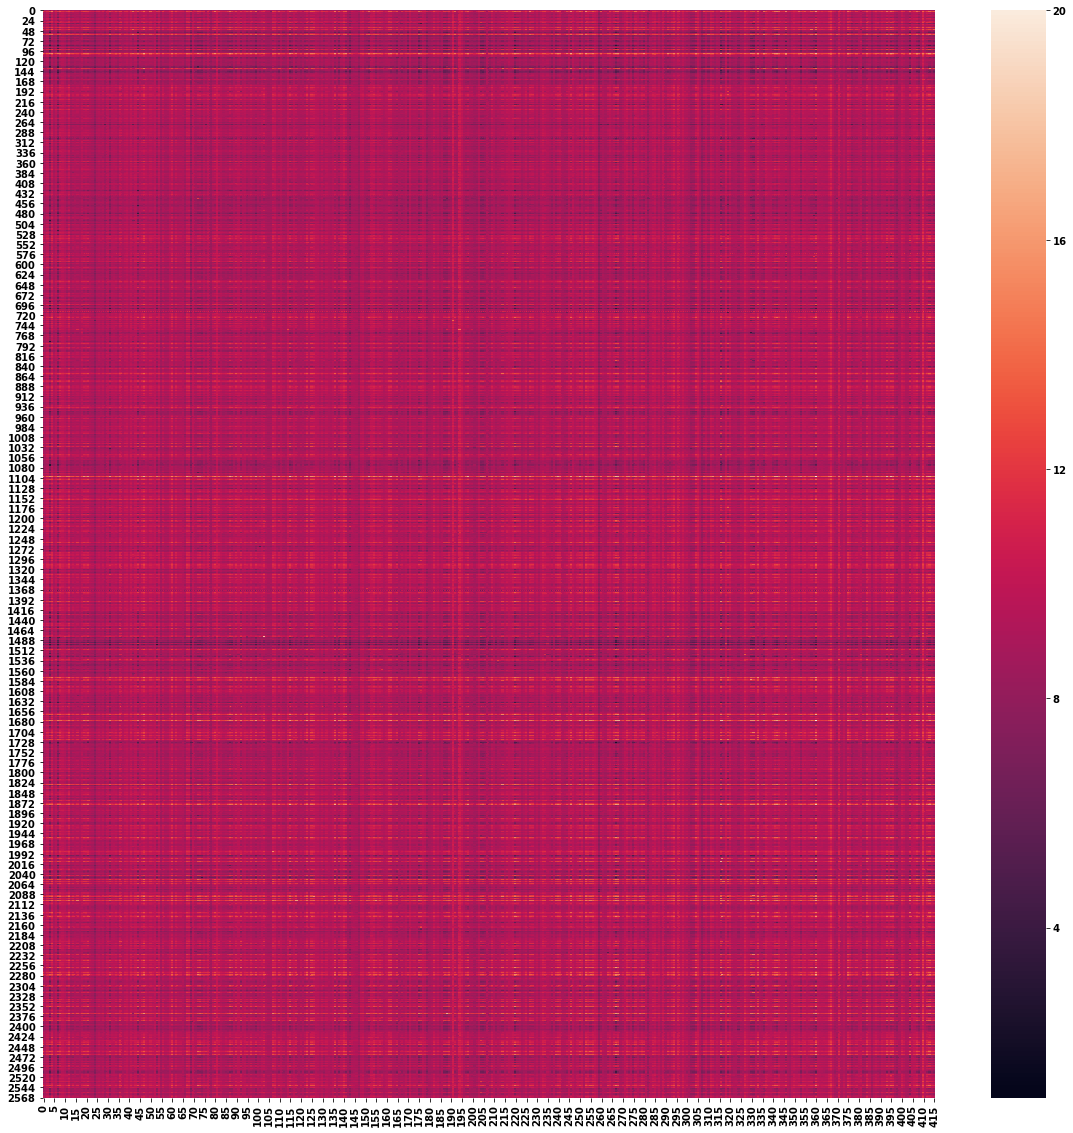

In [37]:
plt.figure(figsize=(20, 20))
sns.heatmap(X3)

In [38]:
pd.DataFrame(X3).to_csv("../output/fact3_result.csv")